In [33]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
import random
import time
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint_MLP_vector.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
AUGMENT_FRACTION = 0.3
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 15

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset_imbalanced, _ = utils.create_train_dataset_imbalanced(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset_imbalanced, validation_dataset_imbalanced, _ = utils.create_test_dataset_imbalanced(validation_split=0.3)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 26821, 1: 27295, 2: 5884}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 26821 campioni (44.70%)
Relazione 1: 27295 campioni (45.49%)
Relazione 2: 5884 campioni (9.81%)




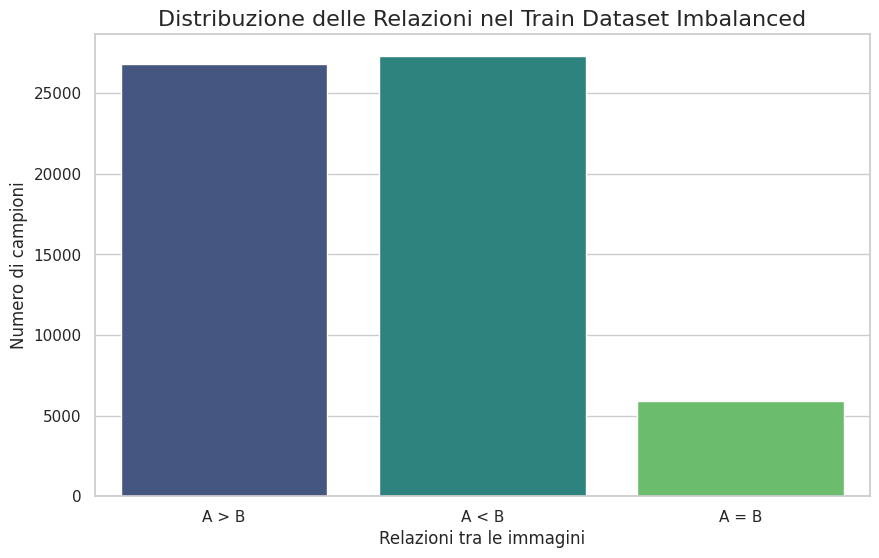

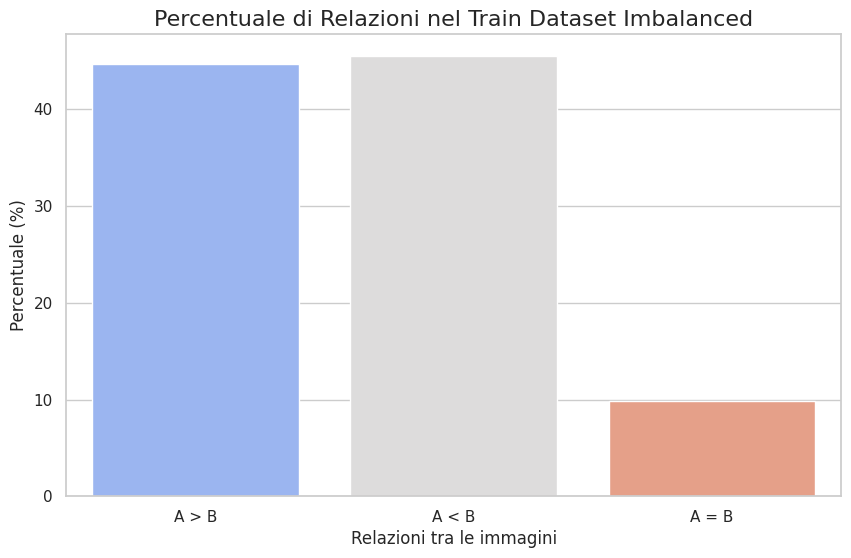

In [3]:
utils.plot_dataset_statistics(train_dataset_imbalanced, "Train Dataset Imbalanced")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 3153, 1: 3164, 2: 683}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 3153 campioni (45.04%)
Relazione 1: 3164 campioni (45.20%)
Relazione 2: 683 campioni (9.76%)




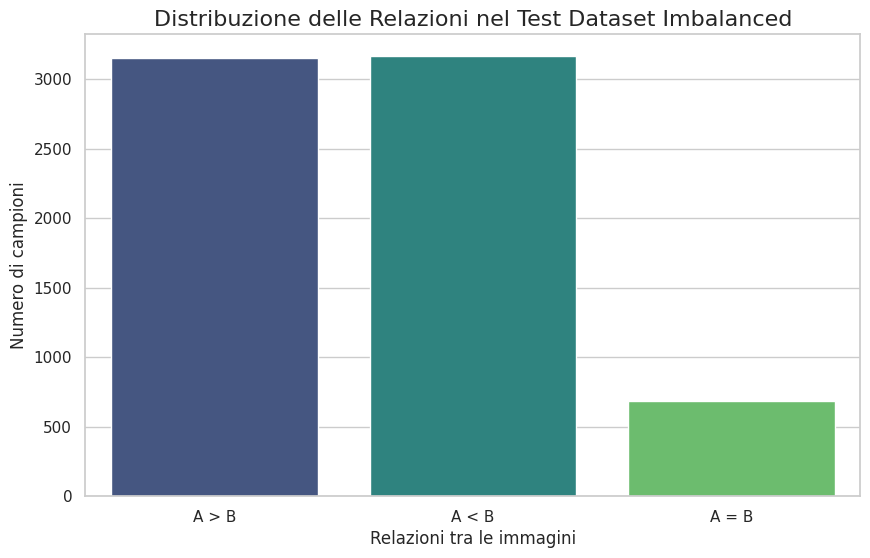

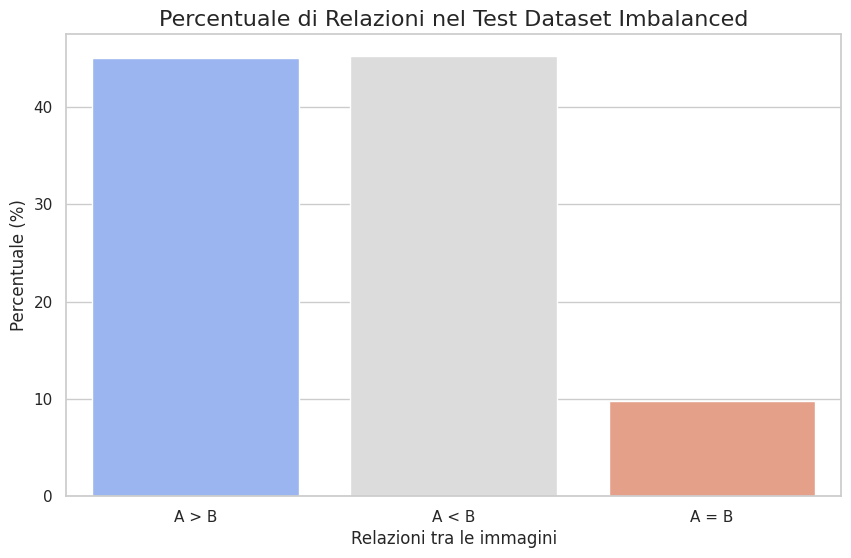

In [4]:
utils.plot_dataset_statistics(test_dataset_imbalanced, "Test Dataset Imbalanced")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 1356, 1: 1361, 2: 283}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 1356 campioni (45.20%)
Relazione 1: 1361 campioni (45.37%)
Relazione 2: 283 campioni (9.43%)




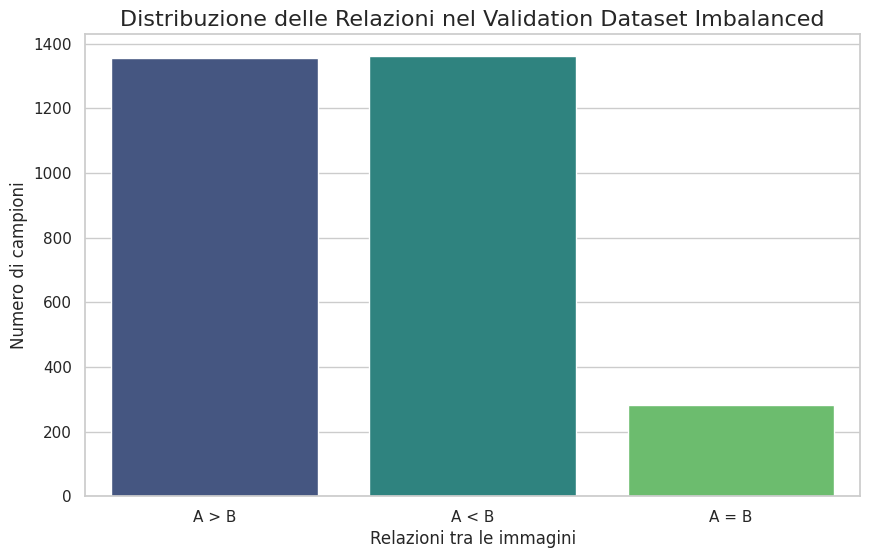

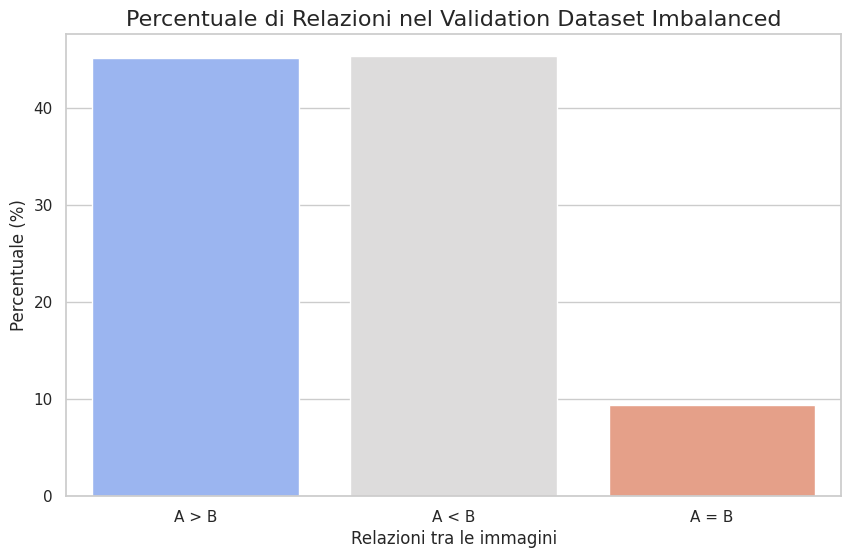

In [5]:
utils.plot_dataset_statistics(validation_dataset_imbalanced, "Validation Dataset Imbalanced")

In [6]:
train_dataset, train_dataset_raw = utils.create_train_dataset_MLP(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset_MLP(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 18000


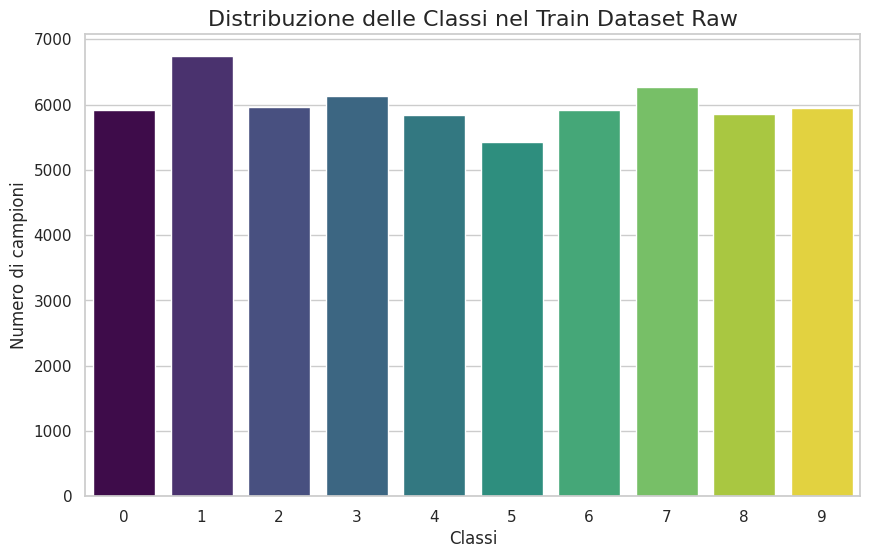

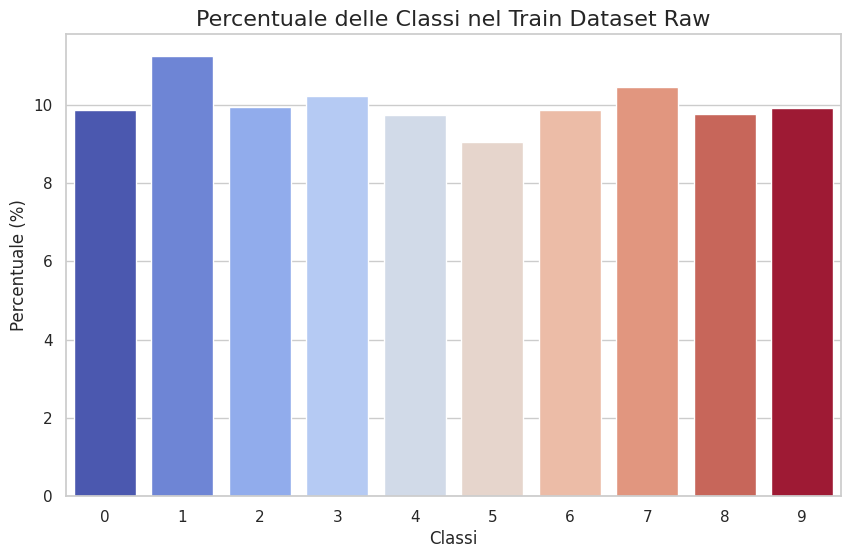

In [7]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 20000, 1: 20000, 0: 20000}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 0: 20000 campioni (33.33%)




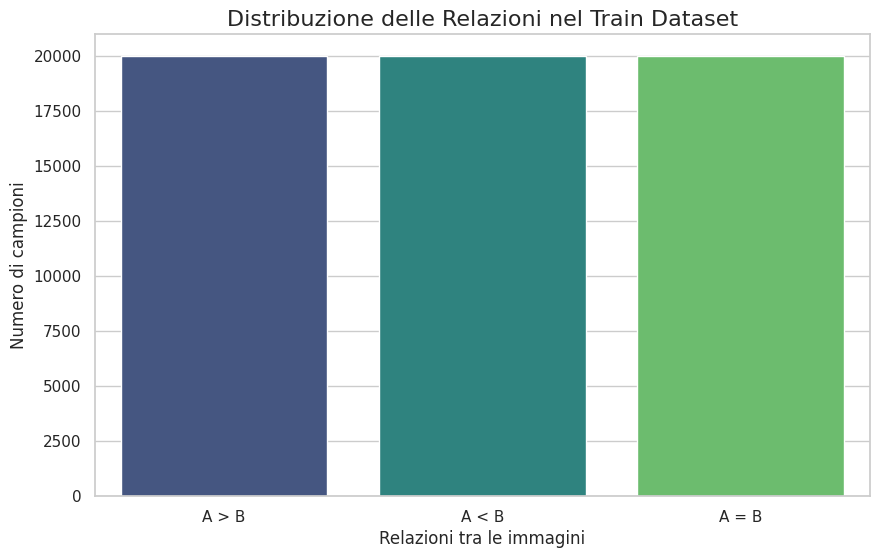

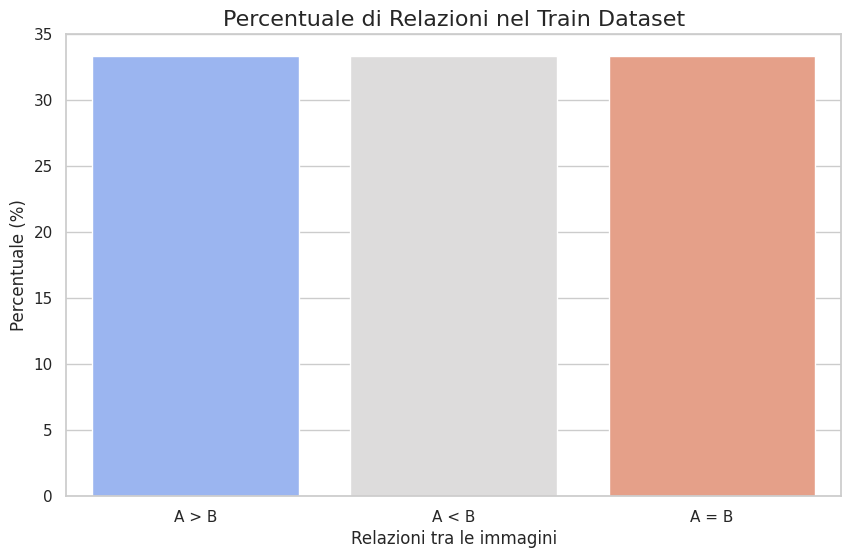

In [8]:
utils.plot_dataset_statistics_MLP(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 1039, 0: 977, 1: 984}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 1039 campioni (34.63%)
Relazione 0: 977 campioni (32.57%)
Relazione 1: 984 campioni (32.80%)




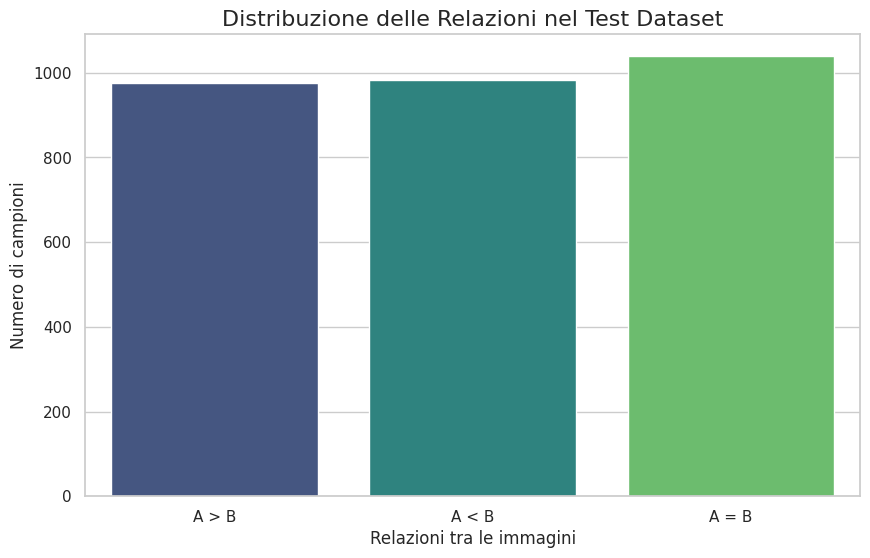

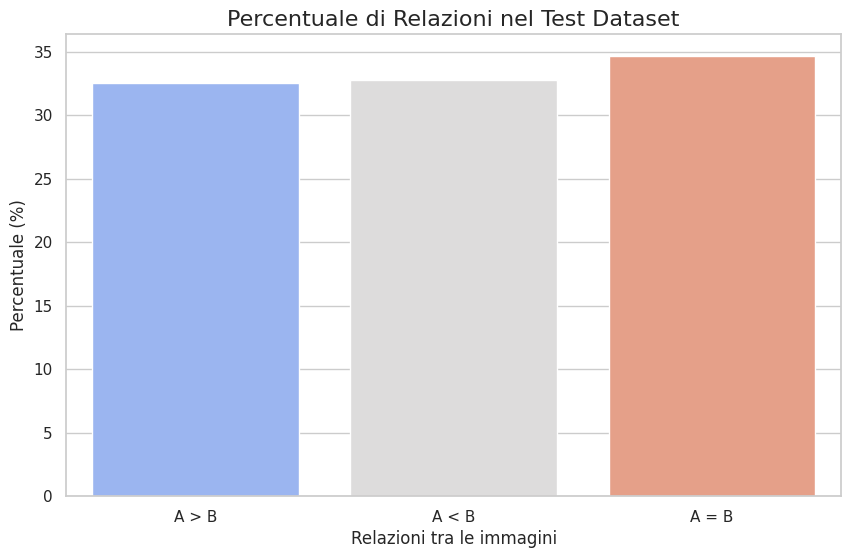

In [9]:
utils.plot_dataset_statistics_MLP(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 2349, 0: 2356, 2: 2294}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 1: 2349 campioni (33.56%)
Relazione 0: 2356 campioni (33.66%)
Relazione 2: 2294 campioni (32.78%)




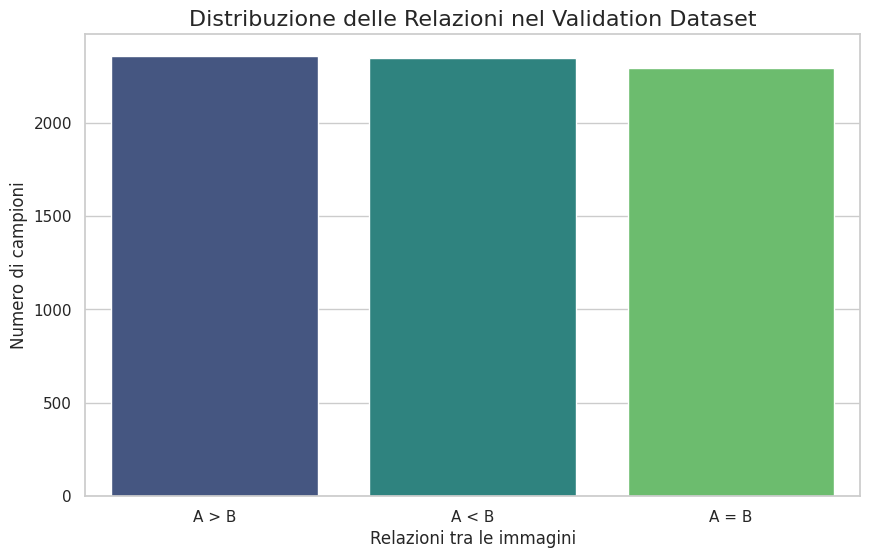

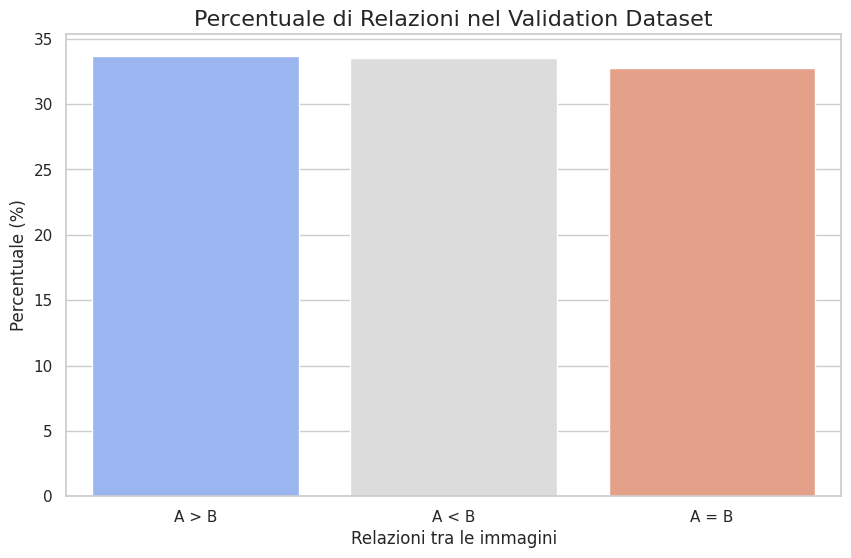

In [10]:
utils.plot_dataset_statistics_MLP(validation_dataset, dataset_name="Validation Dataset")

In [11]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [12]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [20]:
class ComparisonMLP(nn.Module):
    def __init__(self, feature_size):
        super(ComparisonMLP, self).__init__()
        self.fc1 = nn.Linear(feature_size * 2, 64)  # Prende 2 numeri in input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 classi (A > B, A < B, A = B)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 3 classi
        return x


In [21]:
class NumberComparisonModel(nn.Module):
    def __init__(self):
        super(NumberComparisonModel, self).__init__()
        self.cnn = NumberRecognitionCNN()  # Modello CNN per il riconoscimento dei numeri
        self.mlp = ComparisonMLP(feature_size=84)  # MLP per confrontare i due numeri

    def forward(self, img1: torch.Tensor, img2: torch.Tensor):
        # Riconoscimento del numero in ciascuna immagine
        features1 = self.cnn(img1)
        features2 = self.cnn(img2)

        combined_features = torch.cat((features1, features2), dim=1)

        comparison = self.mlp(combined_features)
        
        return comparison


In [22]:
model = NumberComparisonModel()

model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

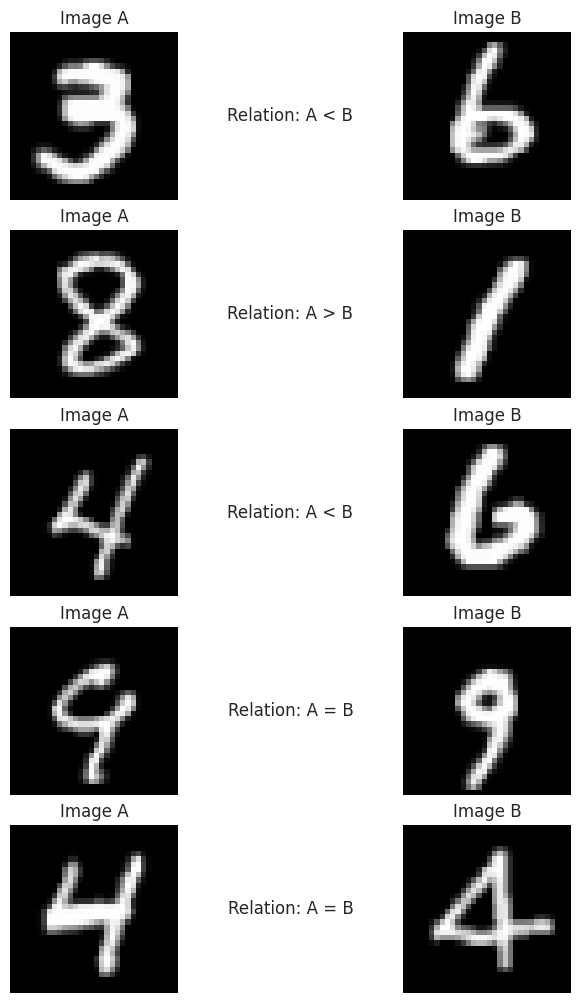

In [23]:
if OPTIMIZER == 'SGD':
    fileName = f"runs/logMLPvector_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/logMLPvector_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottiengo un batch dal dataloader
batch = next(iter(train_loader))
imgs_A, imgs_B, labels = batch

# Divido il batch in due immagini (img_A e img_B)
img_A, img_B = imgs_A[0], imgs_B[0]

img_A = img_A.to(device)
img_B = img_B.to(device)

writer.add_graph(model, (img_A, img_B))

writer.add_figure('Image_pair', utils.show_dataset_MLP(train_loader, 5))


In [24]:
def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(img_A, img_B)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(img_A, img_B)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [25]:
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalar('Learning Rate', current_lr, epoch + 1)
        #writer.add_scalar('Train Loss', train_loss, epoch + 1)
        #writer.add_scalar('Validation Loss', val_loss, epoch + 1)
        #writer.add_scalar('Train Accuracy', train_acc, epoch + 1)
        #writer.add_scalar('Validation Accuracy', val_acc, epoch + 1)
        
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)
        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 15
Training


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.2138: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]


Validating


Loss: 0.2064: 100%|██████████| 55/55 [00:01<00:00, 44.55it/s]


Epoch #1 train loss: 0.516 train accuracy: 78.38
Epoch #1 validation loss: 0.206 validation accuracy: 93.23
Learning rate actual:  0.0009972609476841367
Took 0.365 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 15
Training


Loss: 0.0714: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]


Validating


Loss: 0.1273: 100%|██████████| 55/55 [00:01<00:00, 54.79it/s]


Epoch #2 train loss: 0.126 train accuracy: 95.96
Epoch #2 validation loss: 0.127 validation accuracy: 97.23
Learning rate actual:  0.0009890738003669028
Took 0.366 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 15
Training


Loss: 0.0446: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Validating


Loss: 0.0539: 100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Epoch #3 train loss: 0.067 train accuracy: 97.90
Epoch #3 validation loss: 0.054 validation accuracy: 98.06
Learning rate actual:  0.0009755282581475768
Took 0.366 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 15
Training


Loss: 0.0742: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Validating


Loss: 0.0817: 100%|██████████| 55/55 [00:00<00:00, 62.03it/s]


Epoch #4 train loss: 0.045 train accuracy: 98.56
Epoch #4 validation loss: 0.082 validation accuracy: 98.07
Learning rate actual:  0.0009567727288213003
Took 0.376 minutes for epoch 4
No improvement for 1 epoch(s).
Checkpoint saved at epoch 4.

EPOCH 5 of 15
Training


Loss: 0.0434: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]


Validating


Loss: 0.0516: 100%|██████████| 55/55 [00:00<00:00, 65.70it/s]


Epoch #5 train loss: 0.034 train accuracy: 98.93
Epoch #5 validation loss: 0.052 validation accuracy: 98.63
Learning rate actual:  0.0009330127018922195
Took 0.303 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 15
Training


Loss: 0.0090: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]


Validating


Loss: 0.0987: 100%|██████████| 55/55 [00:00<00:00, 60.84it/s]


Epoch #6 train loss: 0.026 train accuracy: 99.19
Epoch #6 validation loss: 0.099 validation accuracy: 98.54
Learning rate actual:  0.0009045084971874739
Took 0.304 minutes for epoch 6
No improvement for 1 epoch(s).
Checkpoint saved at epoch 6.

EPOCH 7 of 15
Training


Loss: 0.0367: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]


Validating


Loss: 0.0641: 100%|██████████| 55/55 [00:00<00:00, 59.94it/s]


Epoch #7 train loss: 0.021 train accuracy: 99.33
Epoch #7 validation loss: 0.064 validation accuracy: 98.40
Learning rate actual:  0.0008715724127386972
Took 0.300 minutes for epoch 7
No improvement for 2 epoch(s).
Checkpoint saved at epoch 7.

EPOCH 8 of 15
Training


Loss: 0.0039: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]


Validating


Loss: 0.0357: 100%|██████████| 55/55 [00:00<00:00, 63.84it/s]


Epoch #8 train loss: 0.016 train accuracy: 99.51
Epoch #8 validation loss: 0.036 validation accuracy: 98.66
Learning rate actual:  0.0008345653031794292
Took 0.304 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 15
Training


Loss: 0.0162: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]


Validating


Loss: 0.0203: 100%|██████████| 55/55 [00:00<00:00, 61.46it/s]


Epoch #9 train loss: 0.012 train accuracy: 99.66
Epoch #9 validation loss: 0.020 validation accuracy: 98.43
Learning rate actual:  0.0007938926261462366
Took 0.301 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 15
Training


Loss: 0.0325: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Validating


Loss: 0.0647: 100%|██████████| 55/55 [00:01<00:00, 48.98it/s]


Epoch #10 train loss: 0.012 train accuracy: 99.64
Epoch #10 validation loss: 0.065 validation accuracy: 98.60
Learning rate actual:  0.00075
Took 0.360 minutes for epoch 10
No improvement for 1 epoch(s).
Checkpoint saved at epoch 10.

EPOCH 11 of 15
Training


Loss: 0.0018: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Validating


Loss: 0.1039: 100%|██████████| 55/55 [00:01<00:00, 51.11it/s]


Epoch #11 train loss: 0.008 train accuracy: 99.73
Epoch #11 validation loss: 0.104 validation accuracy: 98.73
Learning rate actual:  0.0007033683215379003
Took 0.378 minutes for epoch 11
No improvement for 2 epoch(s).
Checkpoint saved at epoch 11.

EPOCH 12 of 15
Training


Loss: 0.0012: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]


Validating


Loss: 0.0490: 100%|██████████| 55/55 [00:01<00:00, 44.38it/s]


Epoch #12 train loss: 0.007 train accuracy: 99.77
Epoch #12 validation loss: 0.049 validation accuracy: 98.47
Learning rate actual:  0.0006545084971874739
Took 0.382 minutes for epoch 12
No improvement for 3 epoch(s).
Early stopping triggered after 12 epochs.
Checkpoint saved at epoch 12.
Validating


Loss: 0.1681: 100%|██████████| 24/24 [00:00<00:00, 49.42it/s]


Test loss: 0.168 Test accuracy: 98.17


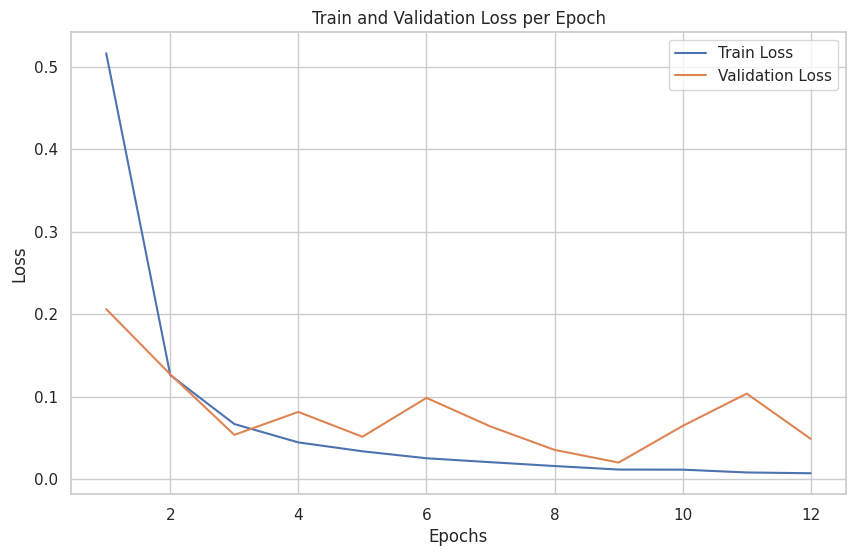

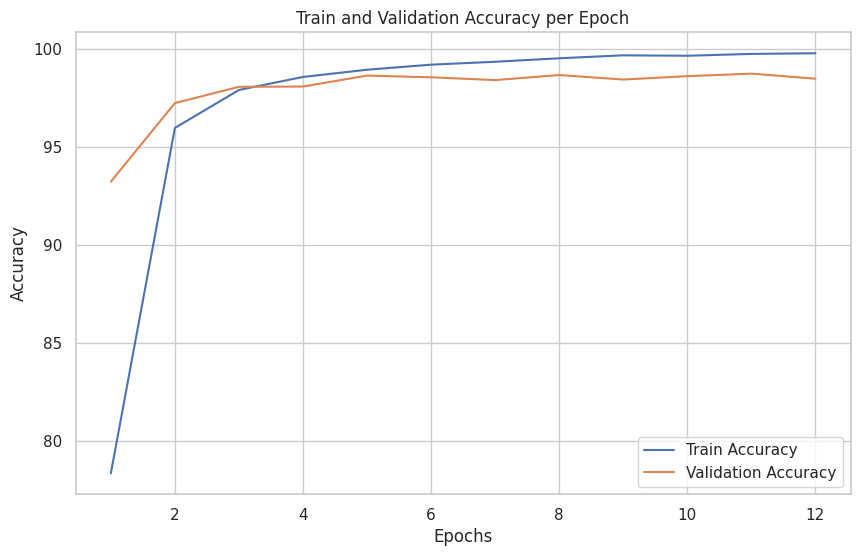

In [26]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

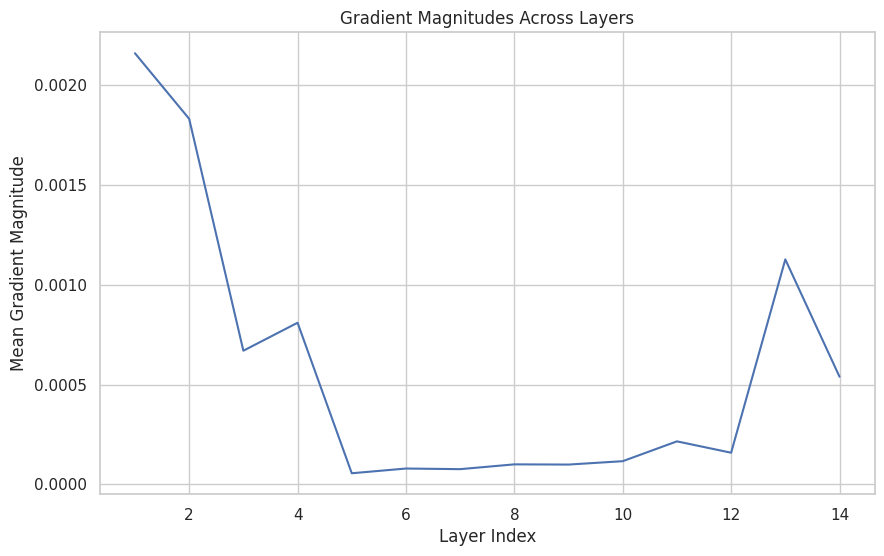

In [27]:
utils.plot_gradient(model)

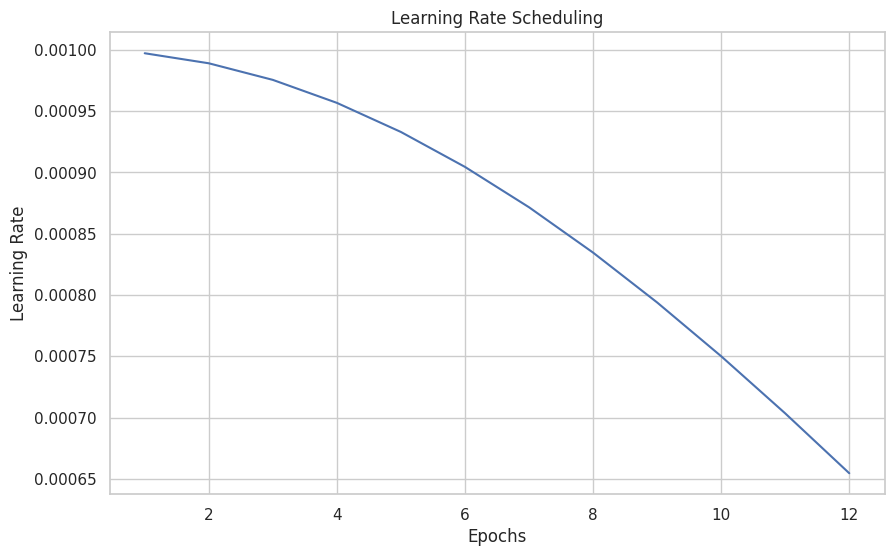

In [28]:
utils.plot_lr_scheduler(learning_rates)

In [31]:
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference_MLPvector(model, test_loader, device)
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference_MLPvector(model, validation_loader, device)

55 previsioni errate trovate.


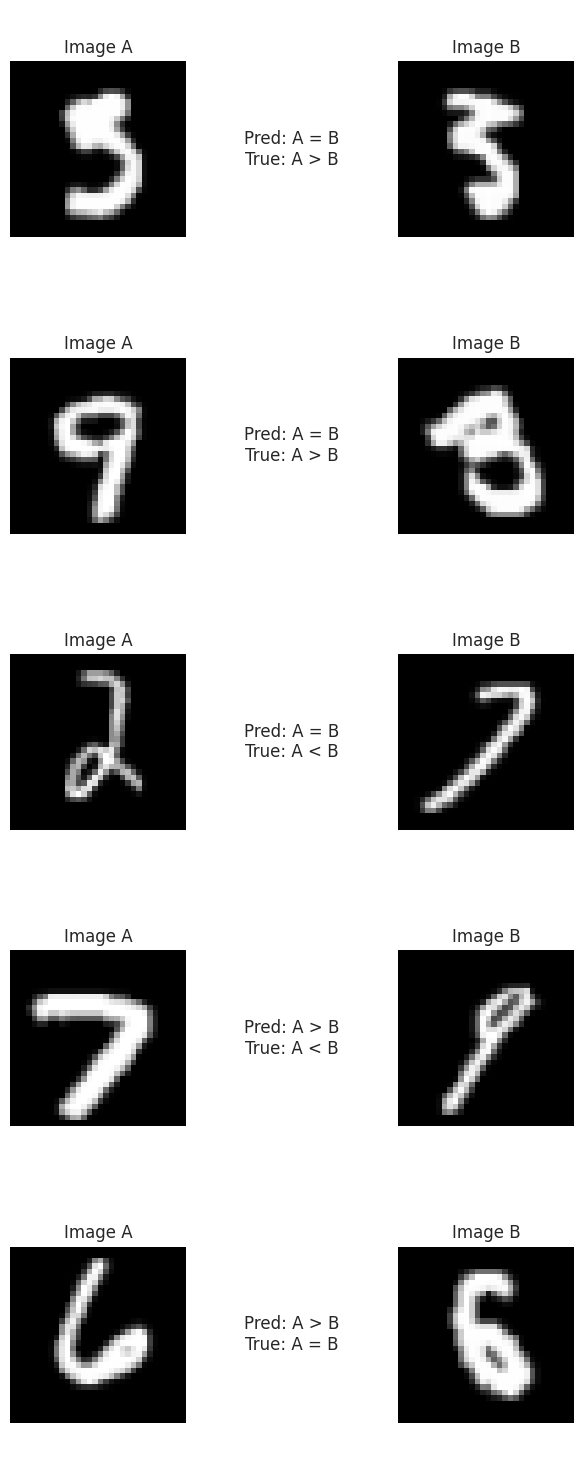

In [35]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions_MLPvector(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, 5))

107 previsioni errate trovate.


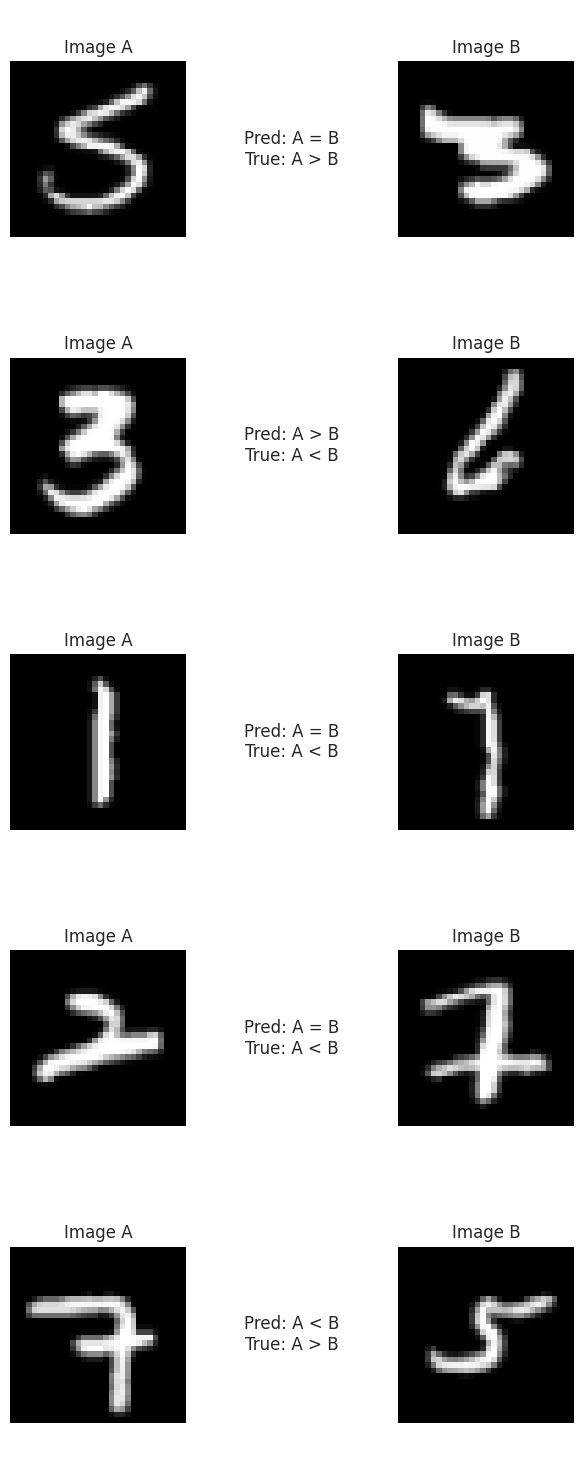

In [36]:
writer.add_figure('Incorrect_predictions_val', utils.show_incorrect_predictions_MLPvector(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, 5))

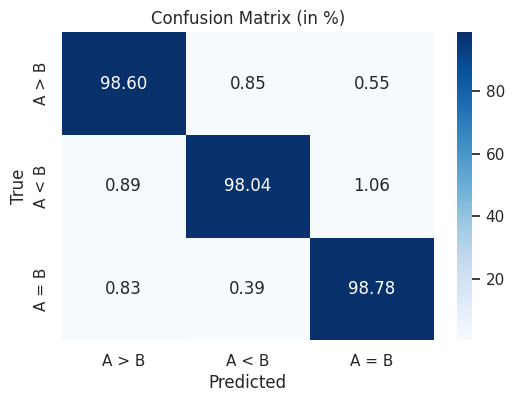

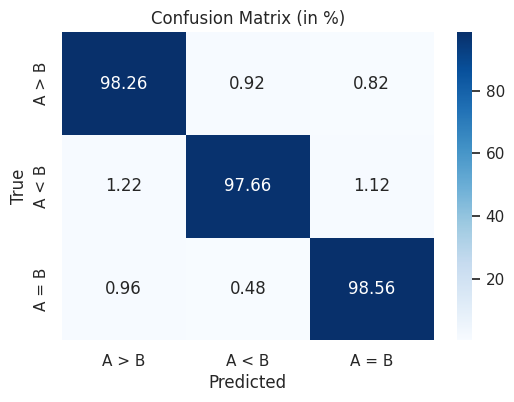

In [37]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [38]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)


              precision    recall  f1-score   support

       A > B       0.98      0.98      0.98       977
       A < B       0.99      0.98      0.98       984
       A = B       0.98      0.99      0.98      1039

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"runMLPvector_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"runMLPvector_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main_MLP_vector.ipynb')


Notebook saved as runMLP_BS=128_LR=0.0001_EPOCHS=15_AUG=True_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()